In [90]:
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np
import html5lib
import requests
from openpyxl import Workbook
from datetime import datetime
import webbrowser

In [91]:
headers = {
    'User-Agent': 'ARES CAPITAL CORP'
}
filing_links = pd.read_excel(
    "/Users/fuadhassan/Desktop/BDC_RA/ARCC/ARCC__sec_filing_links.xlsx")

path = '/Users/fuadhassan/Desktop/BDC_RA/ARCC/ARCC_Investment.xlsx'
xls = pd.ExcelFile(path)
all_sheets = pd.read_excel(path, sheet_name=None)

In [92]:
dataframes = {}
# Loop through each sheet and create a DataFrame in the dictionary
for sheet_name, sheet_df in all_sheets.items():
    dataframes[sheet_name.replace(' ', '_')] = sheet_df
for sheet_name, sheet_df in dataframes.items():
    print(f"DataFrame name: {sheet_name} : {sheet_df.shape}")

DataFrame name: March_31_2013 : (352, 7)
DataFrame name: June_30_2013 : (376, 7)
DataFrame name: September_30_2013 : (368, 7)
DataFrame name: December_31_2013 : (390, 7)
DataFrame name: March_31_2014 : (415, 7)
DataFrame name: June_30_2014 : (406, 7)
DataFrame name: September_30_2014 : (416, 7)
DataFrame name: December_31_2014 : (431, 7)
DataFrame name: March_31_2015 : (415, 7)
DataFrame name: June_30_2015 : (422, 7)
DataFrame name: September_30_2015 : (437, 7)
DataFrame name: December_31_2015 : (454, 7)
DataFrame name: March_31_2016 : (472, 7)
DataFrame name: June_30_2016 : (476, 7)
DataFrame name: September_30_2016 : (480, 7)
DataFrame name: December_31_2016 : (464, 7)
DataFrame name: March_31_2017 : (669, 7)
DataFrame name: June_30_2017 : (678, 7)
DataFrame name: September_30_2017 : (746, 7)
DataFrame name: December_31_2017 : (766, 7)
DataFrame name: March_31_2018 : (794, 7)
DataFrame name: June_30_2018 : (769, 7)
DataFrame name: September_30_2018 : (771, 7)
DataFrame name: December

In [93]:
date_columns = ['Filing date', 'Reporting date']
for col in date_columns:
    filing_links[col] = pd.to_datetime(filing_links[col], format='%Y-%m-%d')
for col in date_columns:
    filing_links[col] = filing_links[col].dt.strftime("%B %d %Y")
filing_links.head()

,Form type,Form description,Filing date,Reporting date,Filings URL
0,10-Q,Quarterly report [Sections 13 or 15(d)],November 04 2010,September 30 2010,https://www.sec.gov/Archives/edgar/data/128775...
1,10-K,"Annual report [Section 13 and 15(d), not S-K I...",March 01 2011,December 31 2010,https://www.sec.gov/Archives/edgar/data/128775...
2,10-Q,Quarterly report [Sections 13 or 15(d)],May 03 2011,March 31 2011,https://www.sec.gov/Archives/edgar/data/128775...
3,10-Q,Quarterly report [Sections 13 or 15(d)],August 04 2011,June 30 2011,https://www.sec.gov/Archives/edgar/data/128775...
4,10-Q,Quarterly report [Sections 13 or 15(d)],November 08 2011,September 30 2011,https://www.sec.gov/Archives/edgar/data/128775...


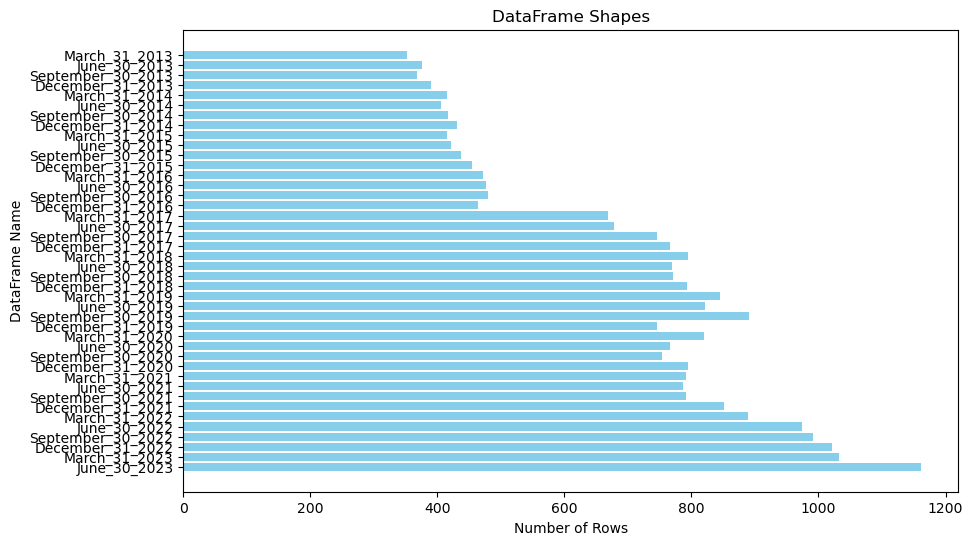

In [94]:
import matplotlib.pyplot as plt

dataframes = {}
# Loop through each sheet and create a DataFrame in the dictionary
for sheet_name, sheet_df in all_sheets.items():
    dataframes[sheet_name.replace(' ', '_')] = sheet_df

# Extract DataFrame names and shapes
df_names = []
df_shapes = []
for sheet_name, sheet_df in dataframes.items():
    df_names.append(sheet_name)
    df_shapes.append(sheet_df.shape)

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.barh(df_names, [shape[0] for shape in df_shapes], color='skyblue')
plt.xlabel('Number of Rows')
plt.ylabel('DataFrame Name')
plt.title('DataFrame Shapes')
plt.gca().invert_yaxis()  # Reverse the order of DataFrame names
plt.show()

In [95]:
for dataframe in dataframes:
    print(dataframes[dataframe].columns.values)

['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Unnamed: 4' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest (5)(10)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest  (5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Unnamed: 4' 'Amortized  Cost' 'Fair  Value']
['Company(1)' 'Business Description' 'Inve

In [96]:
for dataframe in dataframes:
    # Get the columns with "Unnamed" in their names
    unnamed_columns = [
        col for col in dataframes[dataframe].columns if 'Unnamed' in col]
    # Drop the unnamed columns
    dataframes[dataframe].drop(columns=unnamed_columns, inplace=True)
    # Print the updated columns
    print(dataframes[dataframe].columns.values)

['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest (5)(10)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest  (5)(11)'
 'Acquisition  Date' 'Amortized  Cost' 'Fair Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'
 'Amortized  Cost' 'Fair  Value']
['Company(1)' 'Business Description' 'Investment' 'Interest(5)(11)'


In [97]:

column_pattern = {
    r'^Company\s*\((\d+)\)$': 'Company',
    r'^Interest\(\d+\)\(\d+\)$': 'Interest',
    r'^Acquisition\s+Date$': 'Acquisition Date',
    r'^Amortized\s+Cost$': 'Amortized Cost',
    r'^Interest\s+\(\d+\)\(\d+\)$': 'Interest',
    r'^Fair\s+Value$': 'Fair Value',
    r'^Coupon\s+\(\d+\)$': 'Coupon',
    r'^Reference\s+\(\d+\)$': 'Reference',
    r'^Spread\s+\(\d+\)$': 'Spread',
    r'^Maturity\s+Date$': 'Maturity Date',
    r'^Shares/Units$': 'Shares/Units',
    r'^Principal$': 'Principal',
}


def rename_columns_with_pattern(df):
    df.columns = df.columns.to_series().replace(column_pattern, regex=True)


# Iterate through dataframes and apply the column renaming function
for dataframe in dataframes:
    rename_columns_with_pattern(dataframes[dataframe])

# Print the updated columns for each dataframe
for dataframe in dataframes:
    print(dataframes[dataframe].columns.values)

['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest' 'Amortized Cost'
 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest' 'Amortized Cost'
 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'
 'Acquisition Date' 'Amortized Cost' 'Fair Value']
['Company' 'Business Description' 'Investment' 'Interest'

In [98]:
from openpyxl import Workbook

excel_file_name = '/Users/fuadhassan/Desktop/BDC_RA/ARCC/Clean_ARCC_Investment.xlsx'

# Create an Excel writer object
excel_writer = pd.ExcelWriter(excel_file_name, engine='openpyxl')

# Iterate through dataframes and write them to the Excel file
for idx, dataframe in enumerate(dataframes):
    # Write each dataframe to a separate sheet (sheet names will be Sheet1, Sheet2, etc.)
    dataframes[dataframe].to_excel(
        excel_writer, sheet_name=f'{dataframe}', index=False)
    dataframes[dataframe].to_csv('../clean_csv_file/'+dataframe+'.csv')

# Save the Excel file
excel_writer.save()

print(f'Excel file "{excel_file_name}" has been created.')

/var/folders/mf/yrkcqqr56t955_zz9p9f4swc0000gn/T/ipykernel_23022/4195061173.py:16: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()


Excel file "/Users/fuadhassan/Desktop/BDC_RA/ARCC/Clean_ARCC_Investment.xlsx" has been created.
